In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
path = '/Users/xueyining/Downloads/UpdatedResumeDataSet.csv'

df = pd.read_csv(path, encoding='utf-8-sig')

In [8]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [10]:
df.shape[0]

962

In [12]:
df.nunique()

Category     25
Resume      166
dtype: int64

In [14]:
missing_count = df.isnull().sum()
missing_count

Category    0
Resume      0
dtype: int64

# First, we use TfidfVectorizer to create a shared vocabulary and vector space based on all resumes. Then, we transform the Resume column into TF-IDF vectors, capturing the importance of each term within the context of the entire dataset.
# Next, we transform the job description (JD) into the same TF-IDF space using the fitted vectorizer. This ensures the JD and resumes are represented in a consistent feature space, which prepares them for cosine similarity calculation in the next step.

In [17]:
job_description = """
This is a full-time remote role for a Data & Analytics Manager. You’ll be responsible for owning end-to-end data systems—from ingestion and integration to dashboarding and insights generation. You’ll partner closely with both internal performance marketers and client leads to surface trends, improve campaign ROI, and help shape our data infrastructure as we grow.

Key Responsibilities
1. Data Management & Integration
Streamline and standardize data collection across Amazon, Walmart, Instacart, and other retail platforms
Maintain data accuracy, consistency, and security across all internal and external-facing systems
Create and document best practices for ingesting, structuring, and storing marketing and retail data
2. Reporting & Dashboard Development
Build and automate dashboards to track campaign performance and KPIs
Own weekly reporting for clients—highlighting trends, anomalies, and opportunities
Customize reporting structures to fit each client’s objectives and channel mix
3. Campaign Optimization Support
Collaborate with the Performance team to monitor live campaigns and identify optimization levers
Support creative, targeting, and bidding experiments with rigorous tracking and analysis
Report impact of optimizations clearly to both internal stakeholders and clients
4. Data Analysis & Insights
Analyze large, multi-platform datasets to identify growth drivers and performance patterns
Translate raw data into clear, actionable recommendations
Present insights in a concise, strategic format to inform client strategy
5. Collaboration & Process Improvement
Work closely with cross-functional partners to align on campaign goals and data needs
Suggest and implement process improvements to streamline reporting and analysis
Help train team members on tools, dashboards, and best practices for data use

Qualifications
2–4 years of experience in data analysis, performance reporting, or marketing analytics
Strong fluency in Excel, SQL, and data visualization tools (e.g., Looker, Tableau, Power BI)
Familiarity with eCommerce/retail media platforms like Amazon Ads, Walmart Connect, Instacart Ads
Comfortable working with large datasets, drawing insights, and presenting to stakeholders
Clear communicator who thrives in a fast-paced, remote-first environment
Bonus: experience in CPG, ad tech, or retail media agencies
"""

vectorizer = TfidfVectorizer(stop_words='english')
resume_tfidf = vectorizer.fit_transform(df['Resume'])  
jd_tfidf = vectorizer.transform([job_description])  

# The difference between fit_transform and transform is:
# fit_transform is used the first time to train the model. It builds a vector space based on the given dataset (e.g., all resumes).
# transform is used to convert new input (e.g., a job description) into that same vector space,
# so we can measure its similarity against the existing data. 

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(jd_tfidf, resume_tfidf).flatten()

In [22]:
df['MatchScore'] = similarity_scores
top_matches = df.sort_values(by='MatchScore', ascending=False).head(10)


top_matches[['Category', 'MatchScore', 'Resume']].head(10)

,Category,MatchScore,Resume
33,Data Science,0.210038,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
3,Data Science,0.210038,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
23,Data Science,0.210038,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
13,Data Science,0.210038,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
29,Data Science,0.205689,Expertise â Data and Quantitative Analysis â...
19,Data Science,0.205689,Expertise â Data and Quantitative Analysis â...
39,Data Science,0.205689,Expertise â Data and Quantitative Analysis â...
9,Data Science,0.205689,Expertise â Data and Quantitative Analysis â...
685,PMO,0.189534,CORE COMPETENCIES â¢ Maintain processes to en...
703,PMO,0.189534,CORE COMPETENCIES â¢ Maintain processes to en...


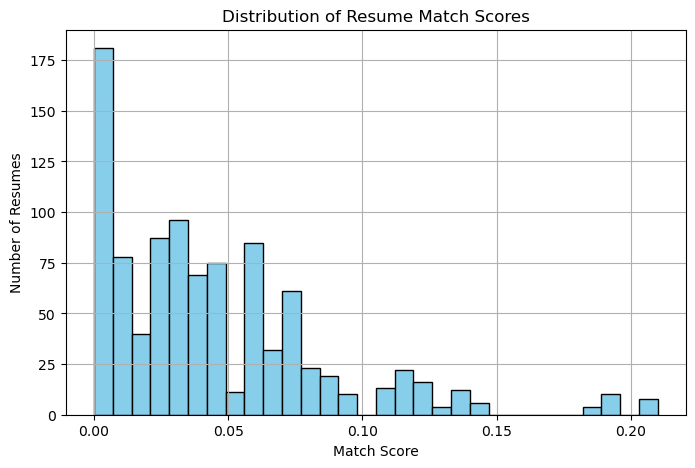

In [24]:
plt.figure(figsize=(8, 5))
plt.hist(df['MatchScore'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Resume Match Scores")
plt.xlabel("Match Score")
plt.ylabel("Number of Resumes")
plt.grid(True)
plt.show()

# The TF-IDF method is a traditional NLP technique that detects text similarity
# based on term frequency in a shared vector space, without understanding semantics.

# Now we apply the BERT-based method to identify the most relevant resumes.

# The key difference: TF-IDF relies on word matching and frequency statistics,
# while BERT captures the actual meaning of text by generating semantic embeddings.

In [27]:
# Install the package if not already installed
# pip install -U sentence-transformers （install the package if not already installed）

# Load pre-trained BERT model for sentence embeddings

In [29]:
from sentence_transformers import SentenceTransformer, util

BERT_model = SentenceTransformer('all-MiniLM-L6-v2')

In [35]:
# Encode resumes and job description into semantic vector space
resume_embeddings = BERT_model.encode(df['Resume'].astype(str).tolist(), convert_to_tensor=True)
jd_embedding = BERT_model.encode(job_description, convert_to_tensor=True)

In [36]:
# calculate the similarity score 
cos_scores = util.pytorch_cos_sim(jd_embedding, resume_embeddings)[0].cpu().numpy()

In [41]:
# display the top 10 resumes in the dataset
df['MatchScore'] = cos_scores
top_matches = df.sort_values(by='MatchScore', ascending=False).head(10)
top_matches

,Category,Resume,MatchScore
750,Hadoop,"Skill Set: Hadoop, Map Reduce, HDFS, Hive, Sqo...",0.545414
778,Hadoop,"Skill Set: Hadoop, Map Reduce, HDFS, Hive, Sqo...",0.545414
764,Hadoop,"Skill Set: Hadoop, Map Reduce, HDFS, Hive, Sqo...",0.545414
743,Hadoop,"Skill Set: Hadoop, Map Reduce, HDFS, Hive, Sqo...",0.545414
757,Hadoop,"Skill Set: Hadoop, Map Reduce, HDFS, Hive, Sqo...",0.545414
771,Hadoop,"Skill Set: Hadoop, Map Reduce, HDFS, Hive, Sqo...",0.545414
33,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,0.524532
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,0.524532
13,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,0.524532
23,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,0.524532


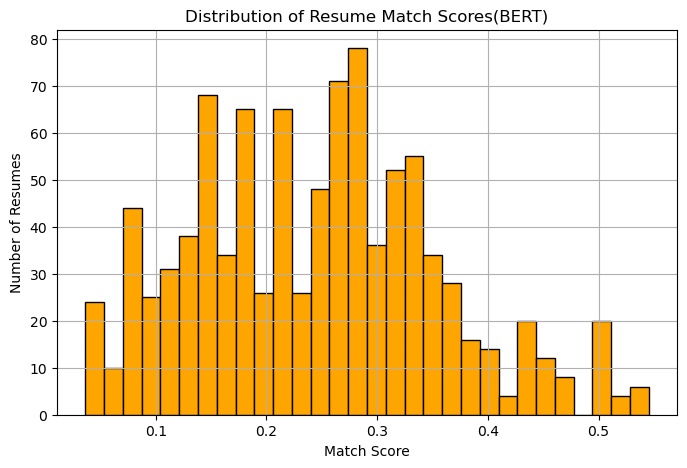

In [47]:
plt.figure(figsize=(8, 5))
plt.hist(df['MatchScore'], bins=30, color='orange', edgecolor='black')
plt.title("Distribution of Resume Match Scores(BERT)")
plt.xlabel("Match Score")
plt.ylabel("Number of Resumes")
plt.grid(True)
plt.show()

In [49]:
# sort out the most fitted candidates by setting the threshold of 0.4
high_score_users = df[df['MatchScore'] > 0.4].index.tolist()
print("User IDs with MatchScore > 0.4:", high_score_users)

User IDs with MatchScore > 0.4: [1, 3, 6, 9, 11, 13, 16, 19, 21, 23, 26, 29, 31, 33, 36, 39, 432, 433, 438, 439, 444, 445, 450, 451, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 710, 715, 721, 726, 732, 737, 742, 743, 744, 745, 748, 749, 750, 751, 752, 755, 756, 757, 758, 759, 762, 763, 764, 765, 766, 769, 770, 771, 772, 773, 776, 777, 778, 779, 780, 783, 787, 792, 797, 802, 807, 812, 817, 822]
